<a href="https://colab.research.google.com/github/yuliavincentia/NLP-Project/blob/main/project_1/Tugas_NLP__Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparation

In [ ]:
!pip install demoji
!pip install PySastrawi
!wget https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 3.5 MB/s eta 0:00:00
--2025-02-07 13:22:11--  https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3093160 (2.9M) [text/plain]
Saving to: ‘colloquial-indonesian-lexicon.csv’

colloquial-indonesi 100%[===================>]   2.95M  --.-KB/s    in 0.08s   

2025-02-07 13:22:11 (38.7 MB/s) - ‘colloquial-indonesian-lexicon.csv’ saved [3093160/3093160]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import demoji
import nltk

from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


nltk.download('stopwords')
nltk.download('punkt')

pd.set_option('display.max_colwidth', None)
sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
url='https://drive.google.com/file/d/1YexiOb6kI5c1SDtziUW9ekcaRoFrqKro/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,sentimen,tweet
0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦"
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ"
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp"
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!"
4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak"


In [ ]:
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


,0
sentimen,0
tweet,0


In [ ]:
print("\nUnique Sentiment Labels:")
print(df['sentimen'].unique())


Unique Sentiment Labels:
['negatif' 'netral' 'positif']


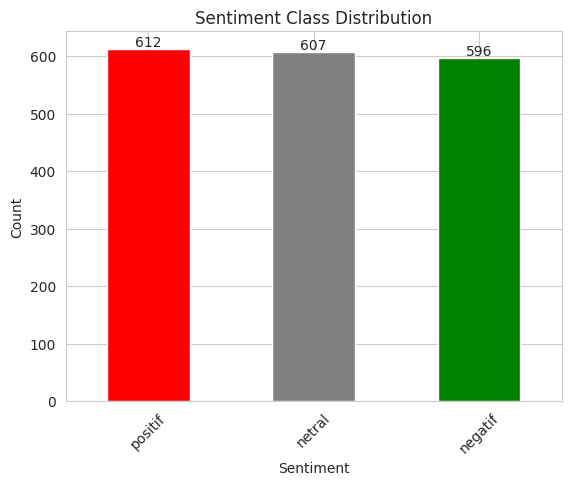

In [ ]:
class_dist = df['sentimen'].value_counts()

ax = class_dist.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Count')

# Add counts on top of the bars
for index, value in enumerate(class_dist):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()


In [ ]:
sentiment_label2id_map = {'negatif': 0, 'netral': 1, 'positif': 2}
sentiment_id2label_map = {0: 'negatif', 1: 'netral', 2: 'positif'}

df['sentimen'] = df['sentimen'].map(sentiment_label2id_map)
df.head()

,sentimen,tweet
0,0,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦"
1,1,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ"
2,1,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp"
3,2,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!"
4,0,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak"


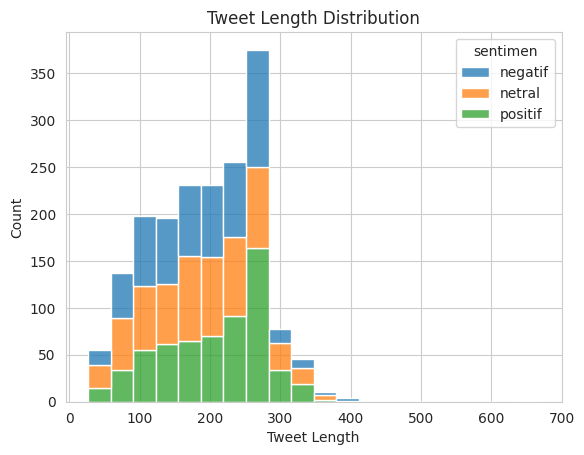

In [ ]:
df['tweet_length'] = df['tweet'].apply(len)
sentimen = df['sentimen'].map(sentiment_id2label_map)
sns.histplot(data=df, x='tweet_length', hue=sentimen, multiple='stack', bins=20)
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Count')
plt.show()

In [ ]:
def count_special_elements(text):
    # Count URLs
    urls = len(re.findall(r'http\S+|www\S+|https\S+', text))
    # Count mentions/hashtags
    mentions_hashtags = len(re.findall(r'[@#]\w+', text))
    # Count emojis
    emojis = len(demoji.findall(text))
    return pd.Series([urls, mentions_hashtags, emojis])

df[['urls', 'mentions_hashtags', 'emojis']] = df['tweet'].apply(count_special_elements)

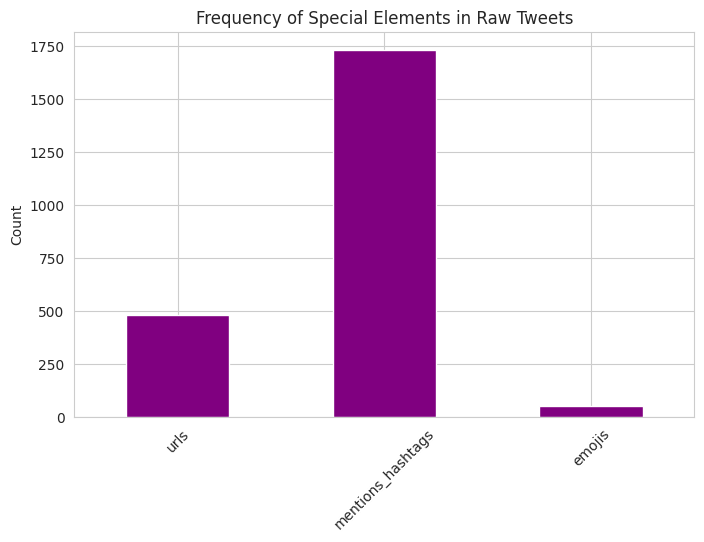

In [ ]:
special_elements = df[['urls', 'mentions_hashtags', 'emojis']].sum()
plt.figure(figsize=(8, 5))
special_elements.plot(kind='bar', color='purple')
plt.title('Frequency of Special Elements in Raw Tweets')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Cleaning

In [ ]:
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)       # Remove ULR
    tweet = re.sub(r'pic.twitter.com\S+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'@\w+|#\w+', '', tweet)                                         # Remove mention & hastags
    tweet = re.sub(r'[^a-zA-Z\s]', ' ', tweet)                                       # Remove special characters & numbers
    tweet = demoji.replace_with_desc(tweet, sep=" ")                                # Remove emojis
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    tweet = re.sub(r'-', ' ', tweet)
    tweet = re.sub(r'(.)\1{2,}', r'\1', tweet)
    tweet = tweet.lower()                                                           # Convert to lowercase
    return tweet

In [ ]:
df['cleaned_tweet'] = df['tweet'].apply(clean_tweet)
print("Cleaned Tweet Example:")
df.sample(10)

Cleaned Tweet Example:


,sentimen,tweet,tweet_length,urls,mentions_hashtags,emojis,cleaned_tweet
859,1,"Sebut Ibu Mia saat Debat Ekonomi Makro, Sandiaga Disemprot Jokowi https://amp.suara.com/news/2019/04/13/221059/sebut-ibu-mia-saat-debat-ekonomi-makro-sandiaga-disemprot-jokowi?utm_source=facebook&utm_medium=fpÂ â€¦",215,1,0,0,sebut ibu mia saat debat ekonomi makro sandiaga disemprot jokowi
855,2,"Semoga Pak @jokowi , di kabinet baru nya nanti memanggil Bapak untuk bertugas membangun ekonomi kita kembali Pak. Orang benar disayang Tuhan. ðŸ™",147,0,1,1,semoga pak di kabinet baru nya nanti memanggil bapak untuk bertugas membangun ekonomi kita kembali pak orang benar disayang tuhan
300,1,"Buat yang ciwi-ciwi, mau harga skincare turun? Tusuk Prabowo Sandi!",67,0,0,0,buat yang ciwi ciwi mau harga skincare turun tusuk prabowo sandi
1189,2,Komunitas olahraga siap deklarasi dukung Jokowi-Maâ€™ruf yang akan dihadiri puluhan atlet dari berbagai cabang olahraga dan ratusan simpatisan. Ini merupakan suatu penghargaan atas kerja hebat Pak Jokowi untuk olahraga Indonesia.,229,0,0,1,komunitas olahraga siap deklarasi dukung jokowi ma ruf yang akan dihadiri puluhan atlet dari berbagai cabang olahraga dan ratusan simpatisan ini merupakan suatu penghargaan atas kerja hebat pak jokowi untuk olahraga indonesia
1502,1,"* Terpilih jadi Presiden/Wapres, Prabowo-Sandi Berjanji Akan Berikan Gajinya bagi Kaum Miskin, Yatim, Dhuafa http://dlvr.it/R2mXdFÂ pic.twitter.com/796gpNykaN",160,1,0,0,terpilih jadi presiden wapres prabowo sandi berjanji akan berikan gajinya bagi kaum miskin yatim dhuafa
710,1,"Arah Pembangunan Ekonomi Salah, Prabowo-Sandi Ingin Referendum Ekonomi https://ekbis.sindonews.com/read/1395738/33/arah-pembangunan-ekonomi-salah-prabowo-sandi-ingin-referendum-ekonomi-1555233172?utm_source=dlvr.it&utm_medium=referralÂ â€¦",240,1,0,0,arah pembangunan ekonomi salah prabowo sandi ingin referendum ekonomi
143,2,"Fyi gaes...Jokowi bangunkan SPBU pertama setelag 71 tahun di Kabupaten Puncak Jaya Papua dengan harga yang semula 50ribu/liter, menjadi 6500/liter.Â http://beritahati.com/berita/38106/Warga-Puncak-Papua-Era-Jokowi-harga-BBM-di-Papua-sama-dengan-pulau-JawaÂ â€¦Â #PilihOrangBaik #PilihJelasIslamnya #PilihBajuPutih",314,1,3,0,fyi gaes jokowi bangunkan spbu pertama setelag tahun di kabupaten puncak jaya papua dengan harga yang semula ribu liter menjadi liter
1631,1,Nawacita @jokowi di nilai sangat sukuses Diantaranya mewujudkan kemandirian ekonomi dengan menggerakkan sektor2 strategis ekonomi domestik. Meningkatkan produktivitas rakyat & daya saing di pasar internasional. Sehingga Indonesia bisa maju #JokowiMenangTotalDebat,263,0,2,0,nawacita di nilai sangat sukuses diantaranya mewujudkan kemandirian ekonomi dengan menggerakkan sektor strategis ekonomi domestik meningkatkan produktivitas rakyat daya saing di pasar internasional sehingga indonesia bisa maju
696,2,"Seperti banyak orang bilang ' Suara Saya Berharga' dalam demokrasi. Makanya saya akan terus bersuara ingatkan janji2 Jokowi sejak 2014& tetap bersuara di pilpres 2019 ini. Suara warga negara bukan sedekah. Suara warga negara adalah kesepakatan politik, bukan sekedar nyoblos! ðŸ˜ŠðŸ˜",284,0,0,0,seperti banyak orang bilang suara saya berharga dalam demokrasi makanya saya akan terus bersuara ingatkan janji jokowi sejak tetap bersuara di pilpres ini suara warga negara bukan sedekah suara warga negara adalah kesepakatan politik bukan sekedar nyoblos
876,1,"Baik berupa kawasan industri kecil baik kawasan ekonomi khusus, kawasan ekonomi khusus pariwisata dan berefek pada barang kerajinan desa dan juga kami ingin terus memperjuangkan kemandirian ekonomi desa,"" papar Jokowi.",218,0,0,0,baik berupa kawasan industri kecil baik kawasan ekonomi khusus kawasan ekonomi khusus pariwisata dan berefek pada barang kerajinan desa dan juga kami ingin terus memperjuangkan kemandirian ekonomi desa papar jokowi


In [ ]:
slang_corpus = pd.read_csv("colloquial-indonesian-lexicon.csv")
slang_corpus = slang_corpus[slang_corpus.columns[0:2]]

slang_dict = dict(zip(slang_corpus['slang'], slang_corpus['formal']))

slang_dict.update({
    "prabowosandi": "prabowo sandi",
    "byr": "bayar",
    "lbh": "lebih",
    "pic.twitter.com": "",
    "jokowimaruf": "jokowi maruf",
    "ri": "republik indonesia",
    "sandy": "sandi",
    "ad": "ada",
    "yg": "yang",
    "dgn": "dengan",
    "pd": "pada",
    "org": "orang",
    "udh": "sudah",
    "hrg": "harga",
    "tgl": "tanggal",
    "km": "kami"
})

In [ ]:
def slang_correction(text):
    words = text.split()
    words = [slang_dict.get(word, word) for word in words]
    return ' '.join(words).strip()

In [ ]:
df['cleaned_tweet'] = df['cleaned_tweet'].apply(slang_correction)
print("Cleaned Tweet Example:")
df.sample(10)

Cleaned Tweet Example:


,sentimen,tweet,tweet_length,urls,mentions_hashtags,emojis,cleaned_tweet
1416,2,"Kreatip nian petani kita. Buat Bpk @Prabowo @Sandi jangan cuma turunkan harga sembako, Tapi tingkatkan pendapatan petani sbg produsen. Saya yakin Bpk punya rumusnya. Kami petani siap memdukung swasembada pangan.",212,0,2,0,kreatip nian petani kita buat bpk jangan cuma turunkan harga sembako tapi tingkatkan pendapatan petani sebagai produsen saya yakin bpk punya rumusnya kami petani siap memdukung swasembada pangan
961,2,"mmng lah luar biasa pendukung 02, presiden RI kl di dlm negeri di hina"" , sdngkan orng luar negeri aja bnr"" bs menghargai presiden jokowi",137,0,0,0,mmng lah luar biasa pendukung presiden republik indonesia kalo di dalam negeri di hina sdngkan orang luar negeri saja benar bisa menghargai presiden jokowi
256,1,"16rb kl anda bl di agen langsung,,malah dapet 15rb... Kl gas 18rb itu dr agen ,ke konsumen .....artinya orang jualan ya pasti cr untung,,itu namane perputaran roda ekonomiðŸ™",176,0,0,1,ribu kalo anda bl di agen langsung malah dapat ribu kalo gas ribu itu dari agen ke konsumen artinya orang jualan ya pasti cara untung itu namane perputaran roda ekonomi
38,2,"#PilihOrangBaik #PilihYgJelasIslamnya #PilihYgBajuPutih ada Beberapa penghargaan yg dianugerahkan kepadanya, menjadi bukti bahwa @jokowi adalah sosok pemimpin yg diakui integritasnya. https://nasional.kompas.com/read/2018/09/24/22563621/disaksikan-sandiaga-jokowi-dapat-penghargaan-tokoh-pemerataan-pembangunanÂ â€¦",316,1,4,0,ada beberapa penghargaan yang dianugerahkan kepadanya menjadi bukti bahwa adalah sosok pemimpin yang diakui integritasnya
923,0,Ini obrolan ngalor ngidul gak jelas blas. Apa urusannya Mobile Legends sama ekonomi nasional? Mengada ada kejauhan banget bicara industri kreatif - seluruh kreasi dan nilai ekonominya kan diekspor lagi keluar? Lalu yg dijual Pak Jokowi semalem itu apa? https://twitter.com/SilasSihot/status/1117317575795306497Â â€¦,320,1,0,0,ini obrolan ngalor ngidul enggak jelas blas apa urusannya mobile legends sama ekonomi nasional mengada ada kejauhan banget bicara industri kreatif seluruh kreasi dan nilai ekonominya kan diekspor lagi keluar lalu yang dijual pak jokowi semalem itu apa
5,1,"Yg bisikin pak jokowi, cm mikirin perputaran duit di golongan tertentu. E-Sports hanya sebagian kecil dr sekian besar penentu pertumbuhan perekonomian Indonesia, bukan hal fundamental. Betul yg dikatakan prabowo, walau dgn bhs yg sederhana, tp mrpkan aspek fundamental ekonomi",276,0,0,0,yang bisikin pak jokowi cuma memikirkan perputaran duit di golongan tertentu e sports hanya sebagian kecil dari sekian besar penentu pertumbuhan perekonomian indonesia bukan hal fundamental betul yang dikatakan prabowo walau dengan bahasa yang sederhana tapi mrpkan aspek fundamental ekonomi
1212,2,"Saat Jokowi mengajarkan ekonomi makro kepada PRABOWO dan SANDIAGA yang merupakan pebisnis kelas nasional, di situ saya merasa..ðŸ˜‹",131,0,0,0,saat jokowi mengajarkan ekonomi makro kepada prabowo dan sandiaga yang merupakan pebisnis kelas nasional di situ saya merasa
493,0,Goblog aje ampe ada yg mempermasalahin Moba PUBG... pak @jokowi cmn ngikutin trend utk milenial utk lbih bisa dipahamin.. kan kalo liat full videonya dia lg bahas EKONOMI DIGITAL.. ESPORT itu salah satunya... PUBG ama MOBA tuh bagian dri ESPORT.. wakkaakaka,257,0,1,0,goblog saja sampai ada yang mempermasalahin moba pubg pak cuman mengikuti trend untuk milenial untuk lebih bisa dipahamin kan kalo lihat full videonya dia lagi bahas ekonomi digital esport itu salah satunya pubg sama moba tuh bagian dari esport wakkaakaka
227,1,Prabowo-Sandi Kembali Tegaskan Tidak Akan Ambil Gaji Bila Terpilih https://politik.rmol.co/read/2019/04/13/385982/Prabowo-Sandi-Kembali-Tegaskan-Tidak-Akan-Ambil-Gaji-Bila-Terpilih-Â â€¦,187,1,0,0,prabowo sandi kembali tegaskan tidak akan ambil gaji bila terpilih
1490,2,"Pengakuan yg jujur bahwa sembako mahal sehingga perlu kartu. Karena permintaan terhadap kartu meningkat , maka sesua

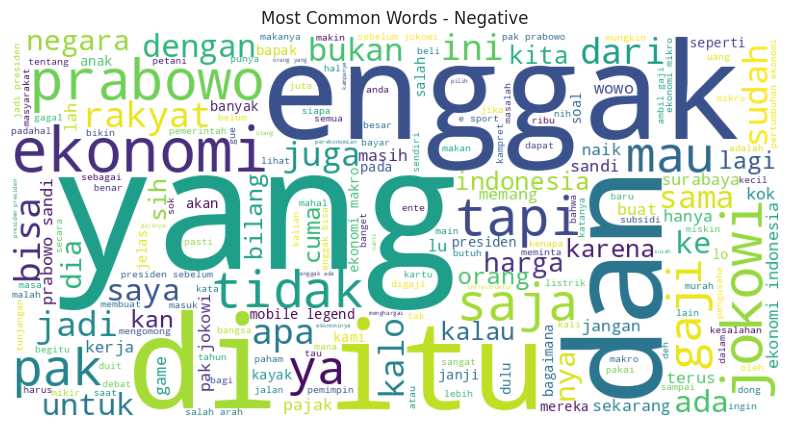

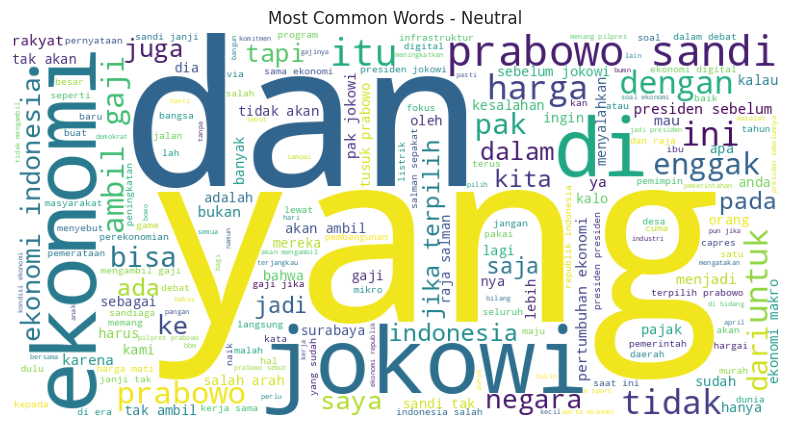

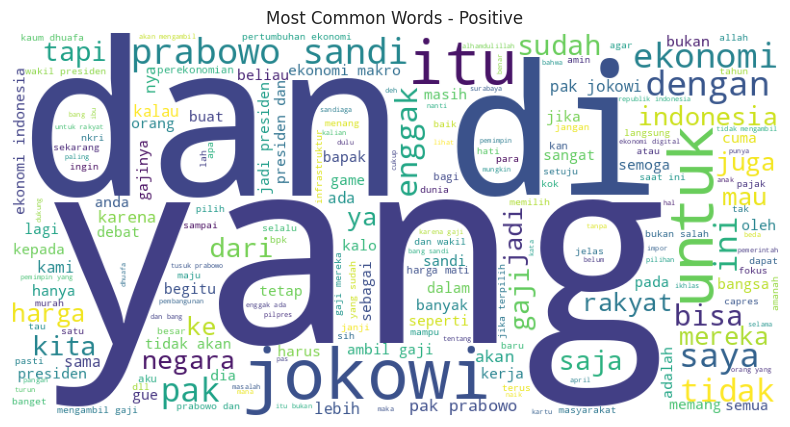

In [ ]:
def generate_wordcloud(sentiment_value, title):
    text = ' '.join(df[df['sentimen'] == sentiment_value]['cleaned_tweet'])
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.title(f'Most Common Words - {title}')
    plt.axis('off')
    plt.show()

# Generate word clouds for each sentiment
generate_wordcloud(0, 'Negative')
generate_wordcloud(1, 'Neutral')
generate_wordcloud(2, 'Positive')

## Bag of Words

In [ ]:
def extract_features_bow(df, max_features=5000):
    bow_vectorizer = CountVectorizer(max_features=max_features)

    X_bow = bow_vectorizer.fit_transform(df['cleaned_tweet'])

    bow_features = bow_vectorizer.get_feature_names_out()

    X_bow_df = pd.DataFrame(X_bow.toarray(), columns=bow_features)

    return {
        'bow_vectorizer': bow_vectorizer,
        'X_bow': X_bow,
        'bow_features': bow_features,
        'X_bow_df': X_bow_df
    }

bow_features = extract_features_bow(df, max_features=5000)

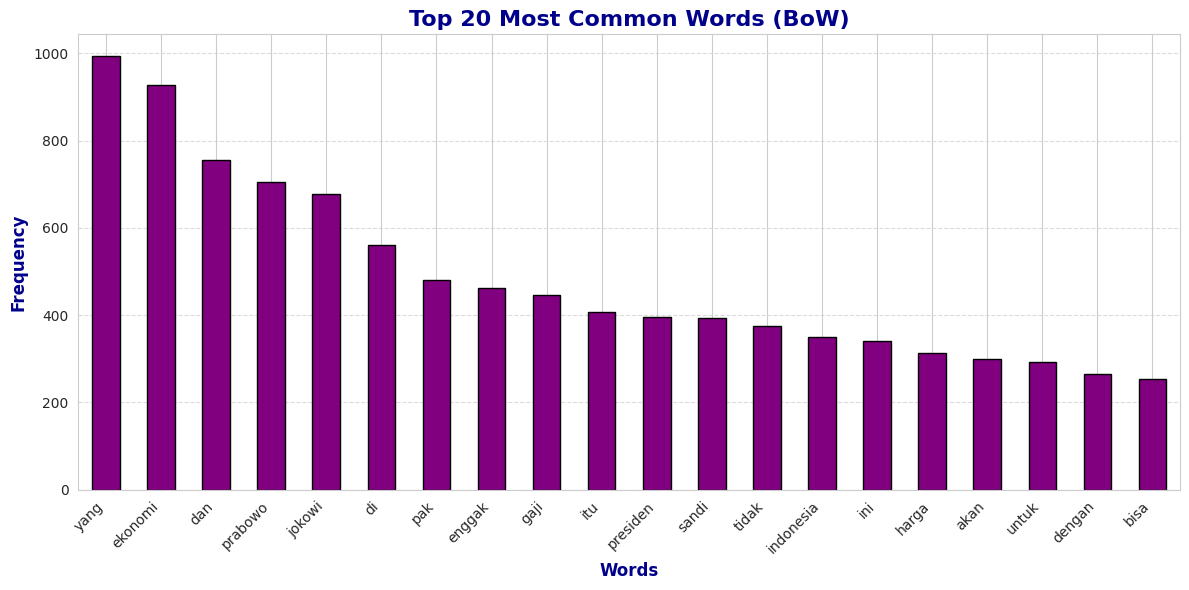

In [ ]:
word_freq = pd.Series(bow_features['X_bow_df'].sum(axis=0)).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
word_freq.head(20).plot(kind='bar', color='purple', edgecolor='black')
plt.title('Top 20 Most Common Words (BoW)', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Words', fontsize=12, fontweight='bold', color='darkblue')
plt.ylabel('Frequency', fontsize=12, fontweight='bold', color='darkblue')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## TF-IDF

In [ ]:
def extract_features_tf_idf(df, max_features=5000):
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_tweet'])
    tfidf_features = tfidf_vectorizer.get_feature_names_out()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_features)

    return {

        'tfidf_vectorizer': tfidf_vectorizer,
        'X_tfidf': X_tfidf,
        'tfidf_features': tfidf_features,
        'X_tfidf_df': X_tfidf_df
    }

# Extract features
tf_idf_features = extract_features_tf_idf(df, max_features=5000)

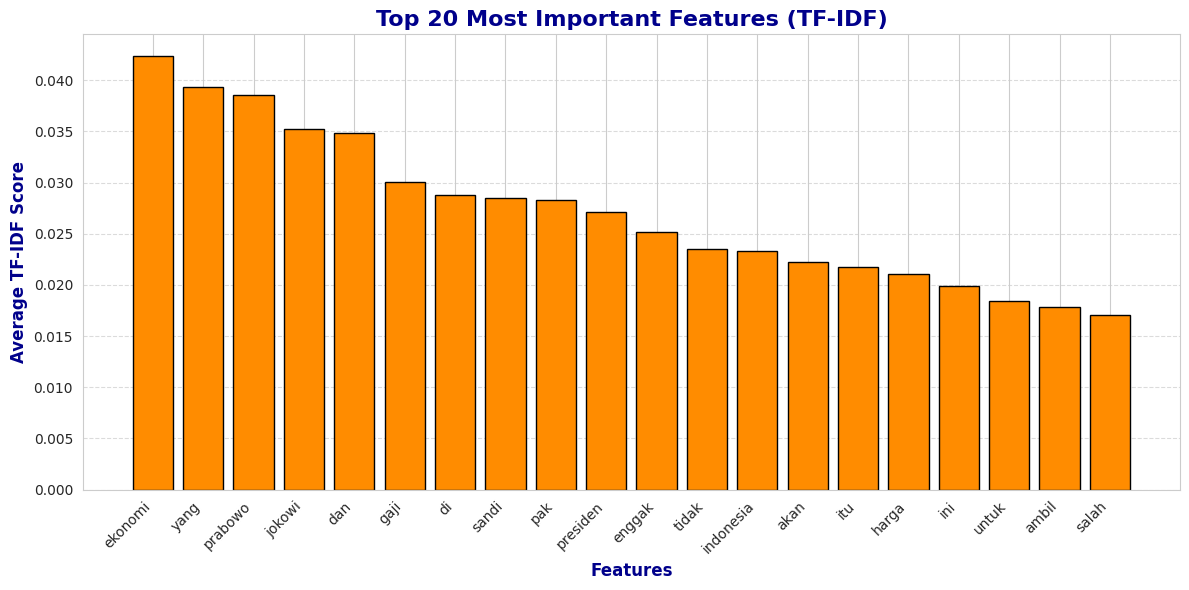

In [ ]:
def analyze_tfidf_importance(tfidf_vectorizer, X_tfidf):
    """
    Analyze and visualize important features based on TF-IDF scores
    """
    feature_names = tfidf_vectorizer.get_feature_names_out()
    avg_tfidf = np.array(X_tfidf.mean(axis=0)).flatten()

    # Create DataFrame of features and their scores
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': avg_tfidf
    }).sort_values('importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 6))
    plt.bar(range(20), feature_importance['importance'][:20], color='darkorange', edgecolor='black')
    plt.xticks(range(20), feature_importance['feature'][:20], rotation=45, ha='right')
    plt.title('Top 20 Most Important Features (TF-IDF)', fontsize=16, fontweight='bold', color='darkblue')
    plt.xlabel('Features', fontsize=12, fontweight='bold', color='darkblue')
    plt.ylabel('Average TF-IDF Score', fontsize=12, fontweight='bold', color='darkblue')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return feature_importance

# Analyze TF-IDF importance
feature_importance = analyze_tfidf_importance(tf_idf_features['tfidf_vectorizer'], tf_idf_features['X_tfidf'])


## Split

In [ ]:
bow_features.keys()

dict_keys(['bow_vectorizer', 'X_bow', 'bow_features', 'X_bow_df'])

In [ ]:
tf_idf_features.keys()

dict_keys(['tfidf_vectorizer', 'X_tfidf', 'tfidf_features', 'X_tfidf_df'])

In [ ]:
X_bow = bow_features['X_bow']
X_tfidf = tf_idf_features['X_tfidf']
y = df['sentimen']

In [ ]:
def split_data(X, y, test_size=0.2):
    return train_test_split(X, y, test_size=test_size, random_state=42)

X_bow_train, X_bow_test, y_train, y_test = split_data(X_bow, y)
X_tfidf_train, X_tfidf_test, _, _ = split_data(X_tfidf, y)

## Random Forest

### BoW


Random Forest (BoW) Accuracy: 0.5895316804407713
Classification Report:
               precision    recall  f1-score   support

     negatif       0.59      0.64      0.62       115
      netral       0.57      0.65      0.61       118
     positif       0.61      0.48      0.54       130

    accuracy                           0.59       363
   macro avg       0.59      0.59      0.59       363
weighted avg       0.59      0.59      0.59       363



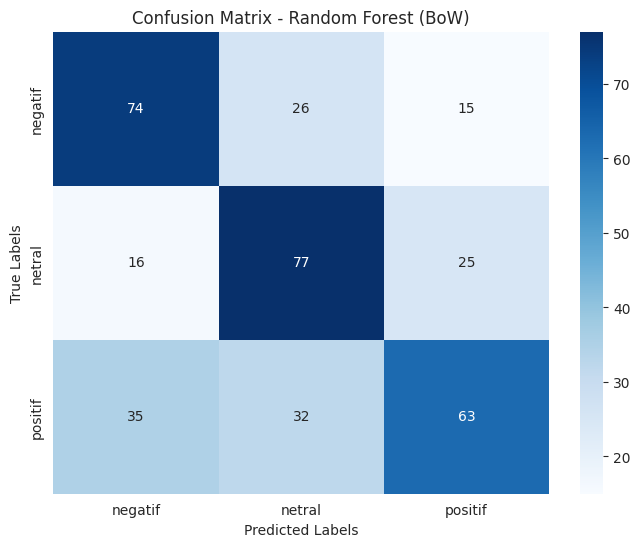

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_bow_train, y_train)
y_pred = rf_classifier.predict(X_bow_test)

print(f"\nRandom Forest (BoW) Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=sentimen.unique()))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sentimen.unique(), yticklabels=sentimen.unique())
plt.title('Confusion Matrix - Random Forest (BoW)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### TF-IDF


Random Forest (BoW) Accuracy: 0.559228650137741
Classification Report:
               precision    recall  f1-score   support

     negatif       0.55      0.63      0.58       115
      netral       0.55      0.58      0.57       118
     positif       0.58      0.48      0.53       130

    accuracy                           0.56       363
   macro avg       0.56      0.56      0.56       363
weighted avg       0.56      0.56      0.56       363



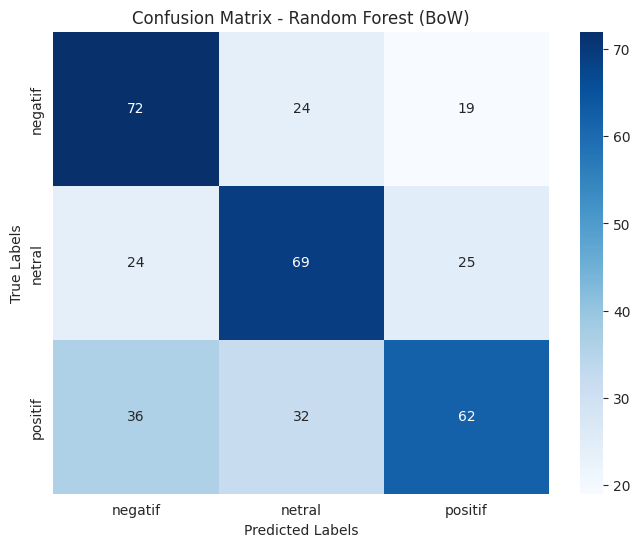

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_tfidf_train, y_train)
y_pred = rf_classifier.predict(X_tfidf_test)

print(f"\nRandom Forest (BoW) Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=sentimen.unique()))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sentimen.unique(), yticklabels=sentimen.unique())
plt.title('Confusion Matrix - Random Forest (BoW)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Hyperparameter Tuning - RF

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, ],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

def tune_random_forest(X_train, y_train, feature_type):
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    print(f"\nBest Parameters for Random Forest with ({feature_type}):")
    print(grid_search.best_params_)

    return grid_search.best_estimator_

In [ ]:
rf_bow_best = tune_random_forest(X_bow_train, y_train, feature_type="BoW")
rf_tfidf_best = tune_random_forest(X_tfidf_train, y_train, feature_type="TF-IDF")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


## LSTM

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(df['cleaned_tweet'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_tweet'])
X_pad = pad_sequences(X_seq, maxlen=50)

In [ ]:
X_train, X_test, y_train, y_test = split_data(X_pad, y)

In [ ]:
def build_lstm_model(vocab_size=6000, embedding_dim=256, max_length=50):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        # Bidirectional(LSTM(64)),
        Bidirectional(LSTM(16, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(8)),
        Dense(128, activation='tanh'),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
lstm_model = build_lstm_model()
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

## TEMP

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

def prepare_balanced_data(df, max_words=6000, max_length=50, test_size=0.2):
    """
    Prepare data with class balancing
    """
    # Tokenization
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(df['cleaned_tweet'])

    # Convert texts to sequences
    X_seq = tokenizer.texts_to_sequences(df['cleaned_tweet'])
    X_pad = pad_sequences(X_seq, maxlen=max_length, padding='post', truncating='post')

    # Calculate class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df['sentimen']),
        y=df['sentimen']
    )
    class_weight_dict = dict(enumerate(class_weights))

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_pad, df['sentimen'],
        test_size=test_size,
        random_state=42,
        stratify=df['sentimen']
    )

    return (X_train, X_test, y_train, y_test), tokenizer, class_weight_dict

def build_balanced_lstm_model(vocab_size=6000, embedding_dim=100, max_length=50):
    """
    Build LSTM model with balanced architecture
    """
    model = Sequential([
        # Embedding layer with reduced dimensions
        Embedding(input_dim=vocab_size,
                 output_dim=embedding_dim,
                 embeddings_regularizer=l2(1e-5)),

        # First Bidirectional LSTM layer
        Bidirectional(LSTM(64, return_sequences=True,
                          kernel_regularizer=l2(1e-5),
                          recurrent_regularizer=l2(1e-5))),
        BatchNormalization(),
        Dropout(0.4),

        # Second Bidirectional LSTM layer
        Bidirectional(LSTM(32,
                          kernel_regularizer=l2(1e-5),
                          recurrent_regularizer=l2(1e-5))),
        BatchNormalization(),
        Dropout(0.4),

        # Dense layers
        Dense(32, activation='relu', kernel_regularizer=l2(1e-5)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(3, activation='softmax')
    ])

    # Use a lower learning rate
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_balanced_model(model, X_train, y_train, X_test, y_test, class_weight_dict, batch_size=32, epochs=50):
    """
    Train model with improved parameters
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-5,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight_dict,
        callbacks=[early_stopping, reduce_lr]
    )

    return history

# Usage
# Prepare data with class balancing
# (X_train, X_test, y_train, y_test), tokenizer, class_weight_dict = prepare_balanced_data(df)
(X_train, X_test, y_train, y_test), tokenizer, class_weight_dict = prepare_balanced_data(df)

y_train = y_train.to_numpy()

# Print class distribution
print("Class distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nClass weights:")
print(class_weight_dict)

# Build and train model
model = build_balanced_lstm_model()
history = train_balanced_model(model, X_train, y_train, X_test, y_test, class_weight_dict)

# Evaluate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()